/tmp/ipykernel_6990/771825885.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty = yf.download("^NSEI", start="2018-01-01", end="2025-07-31")
[*********************100%***********************]  1 of 1 completed


✅ Saved processed data to data/processed/underlying_price.pkl
Loaded back: shape=(1867, 12), columns=['Close', 'High', 'Low', 'Open', 'Volume', 'log_ret', 'vol_band', 'hv10', 'hv20', 'hv30', 'hv10_z', 'hv30_z']
NaNs in hv10: 9


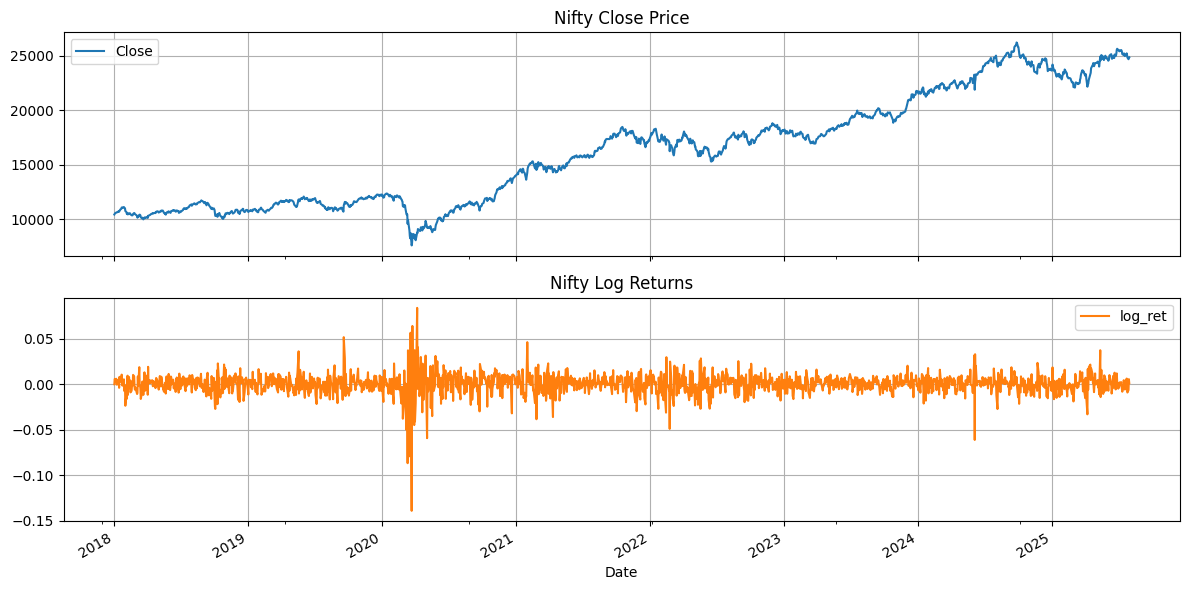

In [1]:
# phase1_data_ingestion.py

import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# =======================
# 1. Download data
# =======================
print("Downloading NIFTY data...")
nifty = yf.download("^NSEI", start="2018-01-01", end="2025-07-31")
nifty.columns = nifty.columns.get_level_values(0)

# =======================
# 2. Calculate log returns
# =======================
nifty['log_ret'] = np.log(nifty['Close'] / nifty['Close'].shift(1))
nifty = nifty.dropna(subset=['log_ret'])

# =======================
# 3. Volatility measures
# =======================
nifty['vol_band'] = nifty['log_ret'].rolling(window=21).std()

nifty['hv10'] = nifty['log_ret'].rolling(10).std() * np.sqrt(252)
nifty['hv20'] = nifty['log_ret'].rolling(20).std() * np.sqrt(252)
nifty['hv30'] = nifty['log_ret'].rolling(30).std() * np.sqrt(252)

# =======================
# 4. Z-scores for HV10 & HV30
# =======================
hv10_clean = nifty['hv10'].dropna()
nifty['hv10_z'] = (nifty['hv10'] - hv10_clean.mean()) / hv10_clean.std()

hv30_clean = nifty['hv30'].dropna()
nifty['hv30_z'] = (nifty['hv30'] - hv30_clean.mean()) / hv30_clean.std()

# =======================
# 5. Save to processed folder
# =======================
os.makedirs("data/processed", exist_ok=True)
save_path = "data/processed/underlying_price.pkl"
nifty.to_pickle(save_path)
print(f"✅ Saved processed data to {save_path}")

# =======================
# 6. Verify save
# =======================
df_check = pd.read_pickle(save_path)
print(f"Loaded back: shape={df_check.shape}, columns={list(df_check.columns)}")
print(f"NaNs in hv10: {df_check['hv10'].isna().sum()}")

# =======================
# 7. (Optional) Plots
# =======================
nifty[['Close', 'log_ret']].plot(subplots=True, figsize=(12, 6),
                                 title=["Nifty Close Price", "Nifty Log Returns"], grid=True)
plt.tight_layout()
plt.show()
